Libralies

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import torch
from datetime import datetime, timedelta
from yahoo_fin.stock_info import get_data
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
from fedot.api.main import Fedot
from forecast_models import company_cross_validation, company_cross_validation, companies_validation, linear_model, multilinear_model, naive_model, random_forest_model, AML_model
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
pd.options.mode.chained_assignment = None 

Constants

In [2]:
PATH_OF_TRAIN_DATA = os.path.dirname(os.path.abspath('eda.ipynb')) + '\\oil_gas_train\\'
PATH_OF_TEST_DATA = os.path.dirname(os.path.abspath('eda.ipynb')) + '\\oil_gas_train_test\\'
stock_data = {}

Functions

In [3]:
def download_data(path: str) -> pd.DataFrame:
    names_of_train_tables = os.listdir(path)
    # i do not want to append data to dataframe by parts, so i use dictionary at the beginning
    Container_for_dataframe = {"company_name": [], "rev": [], "date": [], "op_in": []}
    for name in names_of_train_tables:
        name_of_table = PATH_OF_TRAIN_DATA + name
        data = pd.read_excel(name_of_table)
        rev = data.iloc[28].tolist()[9:51]
        date = data.iloc[27].tolist()[9:51]
        op_in = data.iloc[42].tolist()[9:51]
        company_name = name[:-5]
        for i in range(len(rev)):
            Container_for_dataframe["company_name"].append(company_name)
            Container_for_dataframe["rev"].append(rev[i])
            Container_for_dataframe["date"].append(date[i])
            Container_for_dataframe["op_in"].append(op_in[i])
    DF = pd.DataFrame(Container_for_dataframe)
    #don't want to get null data
    DF = DF.loc[DF['rev'] != 0]
    return DF

In [4]:
def get_stock_price_for_date(date: datetime, ticker: str, 
                                 start_date: datetime = datetime(2011, 3, 1),
                                 end_date: datetime = datetime(2020, 7, 30)) -> float:
    if date < start_date:
        return 50513.14505
    if ticker not in stock_data:
        stock_data[ticker] = get_data(ticker, start_date = start_date, end_date = end_date, index_as_date = True, interval="1d").open 
        stock_data[ticker] = stock_data[ticker].dropna()       
    price_for_date = stock_data[ticker].loc[stock_data[ticker].index < date][-1]
    return price_for_date

In [5]:
calculated = False
automl_parameters = {}
def FEDOT_model(data: pd.DataFrame, name_of_column: str, recalculate: bool = False) -> float:
    """Least squares Linear Regression with multiply variables."""
    global calculated, automl_parameters 
    if not calculated or recalculate:
        N_THREADS = 4
        N_FOLDS = 5
        RANDOM_STATE = 42
        TEST_SIZE = 0.2
        TIMEOUT = 300
        TARGET_NAME = 'TARGET'
        calculated = True
        task = Task('reg')
        automl_parameters = TabularAutoML(task = task, timeout = TIMEOUT, cpu_limit = N_THREADS,
                                reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE})
        roles = {'target': name_of_column}
        AML_fit_predict = automl_parameters.fit_predict(data[["rev","op_in","usd"]], roles = roles, verbose = 1)
    next_value = automl_parameters.predict(data[["rev","op_in","usd"]])[0].data[0]
    return next_value

Download data

In [6]:
Train_DF = download_data(PATH_OF_TRAIN_DATA)

Distributed the data across three clusters using k-means. There are three clusters, and in one of them there is only one point with drastically different values from others. So i just drop it.

In [7]:
revenues = pd.DataFrame(Train_DF.groupby('company_name')['rev'].mean())
op_ins = pd.DataFrame(Train_DF.groupby('company_name')['op_in'].mean())
clasterization = pd.concat([revenues,op_ins], axis=1, join='inner').reset_index()
kmeans = KMeans(n_clusters=3) 
kmeans.fit(np.array(clasterization['rev']).reshape((-1,1)), clasterization['op_in'])
clasterization['claster'] = kmeans.labels_
clasterization = clasterization.drop(clasterization[(clasterization.claster == 2)].index)

I divide the data into two clusters in order to do different processing for them in the future.

In [8]:
Train_DF_Small = clasterization.loc[clasterization.claster == 0]
Train_DF_Small.drop('claster', axis = 1)
Train_DF_Mid = clasterization.loc[clasterization.claster == 1]
Train_DF_Mid.drop(columns = ['claster', 'rev', 'op_in'])
Train_DF_midlle = Train_DF[Train_DF['company_name'].isin(Train_DF_Mid.company_name)] 
Train_DF_small = Train_DF[Train_DF['company_name'].isin(Train_DF_Small.company_name)] 

Find mse for naive model

In [9]:
Validation_small_rev = companies_validation(Train_DF_small,'rev', naive_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Train_DF_small,'op_in', naive_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Train_DF_midlle,'rev', naive_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Train_DF_midlle,'op_in', naive_model, mean_absolute_error)

In [10]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    51.69805
dtype: float64
op_in    48.933637
dtype: float64
rev    306.893456
dtype: float64
op_in    249.094686
dtype: float64


Test data. I do everything similarly to the training sample.

In [11]:
Test_DF = download_data(PATH_OF_TEST_DATA)

In [12]:
Test_DF["usd"] = Test_DF["date"].map(lambda y: get_stock_price_for_date(y,"USDRUB=X"))
Test_DF["oil"] = Test_DF["date"].map(lambda y: get_stock_price_for_date(y,"BZ=F"))

In [13]:
revenues = pd.DataFrame(Test_DF.groupby('company_name')['rev'].mean())
op_ins = pd.DataFrame(Test_DF.groupby('company_name')['op_in'].mean())
clasterization = pd.concat([revenues,op_ins], axis=1, join='inner').reset_index()
kmeans = KMeans(n_clusters=3) 
kmeans.fit(np.array(clasterization['rev']).reshape((-1,1)), clasterization['op_in'])

KMeans(n_clusters=3)

In [14]:
clasterization['claster'] = kmeans.labels_
clasterization = clasterization.drop(clasterization[(clasterization.claster == 1)].index)
Test_DF_Small = clasterization.loc[clasterization.claster == 0]
Test_DF_Small.drop('claster', axis = 1)
Test_DF_Mid = clasterization.loc[clasterization.claster == 2]
Test_DF_Mid.drop(columns = ['claster', 'rev', 'op_in'])
Test_DF_midlle = Test_DF[Test_DF['company_name'].isin(Test_DF_Mid.company_name)] 
Test_DF_small = Test_DF[Test_DF['company_name'].isin(Test_DF_Small.company_name)]
Validation_small_rev = companies_validation(Test_DF_small,'rev', naive_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', naive_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', naive_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', naive_model, mean_absolute_error) 

In [15]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    52.722084
dtype: float64
op_in    50.144816
dtype: float64
rev    306.893456
dtype: float64
op_in    249.094686
dtype: float64


In [16]:
Validation_small_rev = companies_validation(Test_DF_small,'rev', linear_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', linear_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', linear_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', linear_model, mean_absolute_error) 

In [17]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    86.596444
dtype: float64
op_in    62.278786
dtype: float64
rev    983.335832
dtype: float64
op_in    424.698657
dtype: float64


Linear Regression with multiply variables with data about USDRUB

In [18]:
Validation_small_rev = companies_validation(Test_DF_small,'rev', multilinear_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', multilinear_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', multilinear_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', multilinear_model, mean_absolute_error)

Results are better than for simple linear regression but still they are worse than naive model

In [19]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    59.895678
dtype: float64
op_in    72.675673
dtype: float64
rev    450.193068
dtype: float64
op_in    234.528025
dtype: float64


AML, baseline, 300 seconds

In [28]:
Validation_small_rev = companies_validation(Test_DF_small,'rev', AML_model, mean_absolute_error)

[23:54:26] Stdout logging level is INFO.
[23:54:26] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[23:54:26] Task: reg

[23:54:26] Start automl preset with listed constraints:
[23:54:26] - time: 300.00 seconds
[23:54:26] - CPU: 4 cores
[23:54:26] - memory: 16 GB

[23:54:26] Train data shape: (22, 3)

[23:54:28] Layer 1 train process start. Time left 298.14 secs
[23:54:28] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:54:30] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -494.1772815593766
[23:54:30] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:54:30] Time left 296.49 secs

[23:54:30] Selector_LightGBM fitting and predicting completed
[23:54:30] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:54:30] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1865.1032249846294
[23:54:30] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[23:54:30] Start hyperparameters optimization for Lvl_0_Pipe

In [29]:
Some_companies_small = Test_DF_small.company_name.unique()[:4]

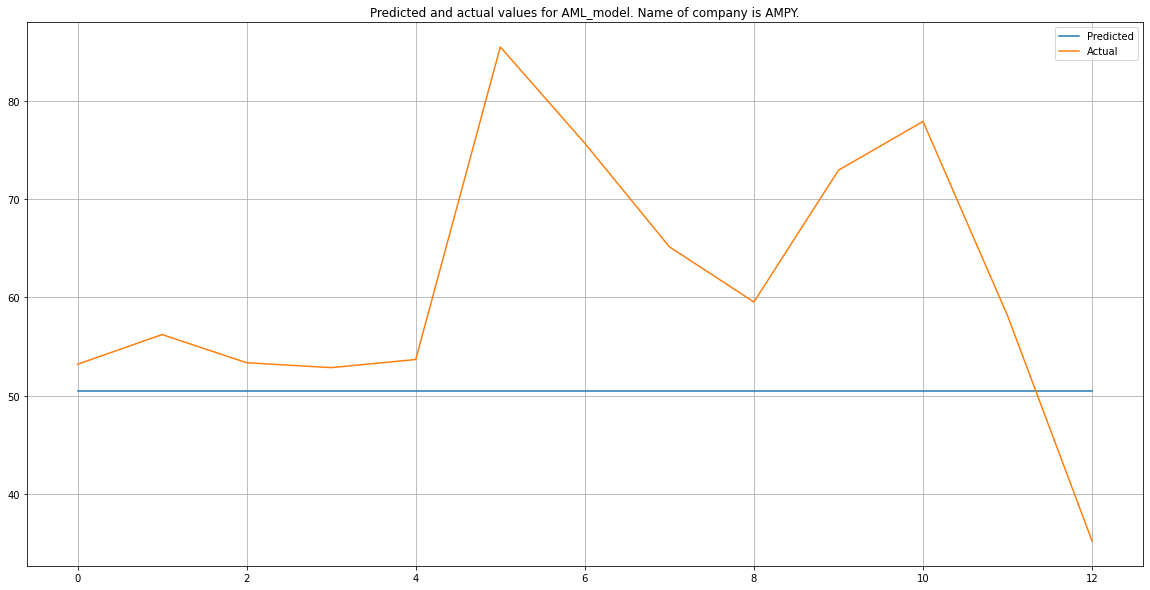

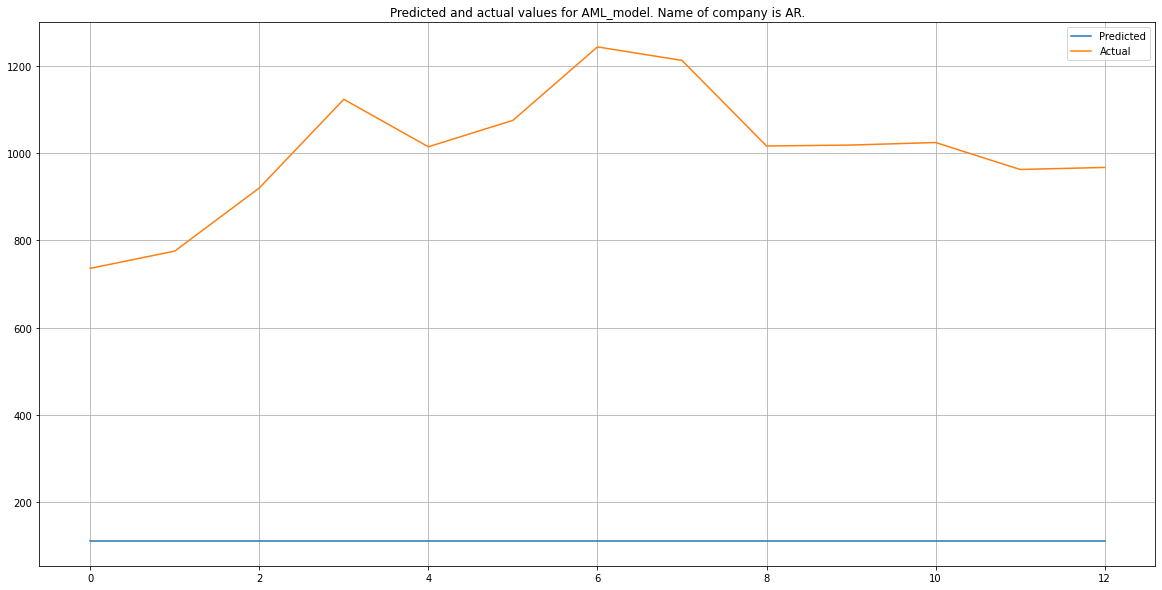

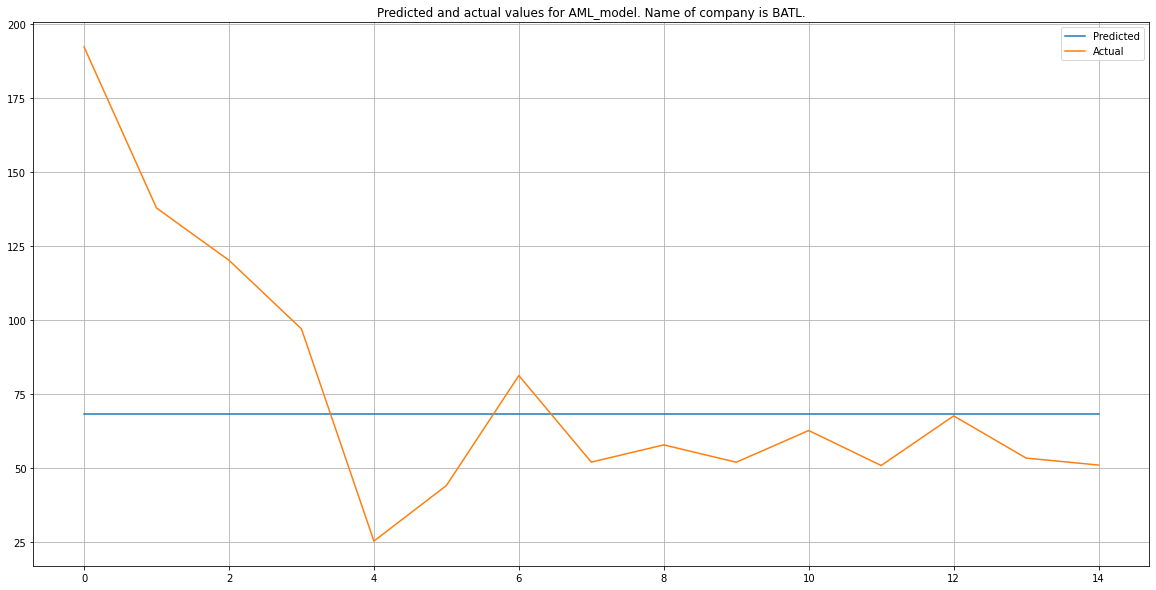

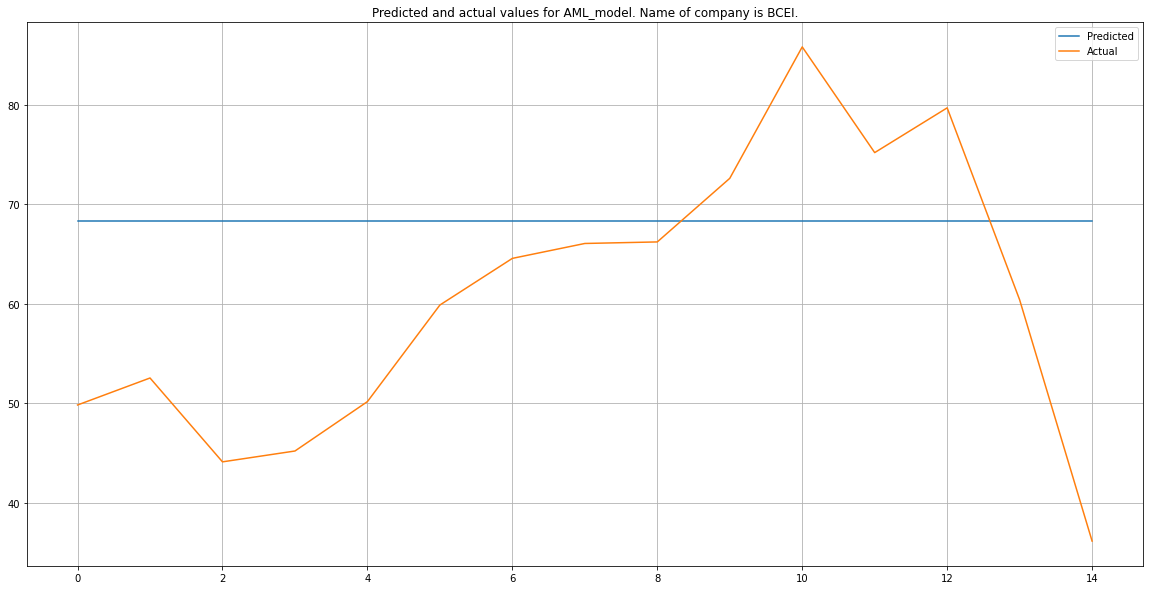

,rev
AMPY,13.389677
AR,894.982409
BATL,30.222249
BCEI,13.061436


In [30]:
companies_validation(Test_DF_small[Test_DF_small['company_name'].isin(Some_companies_small)] ,'rev', AML_model, mean_absolute_error, plot = True)

In [31]:
print(Validation_small_rev.mean())

rev    866.28281
dtype: float64


We can see that results are quite bad and prediction is simular to something like mean model. Probably, we got such results because of small amount of data.

FEDOT model

In [31]:
def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    """
    Function for drawing plot with predictions
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.scatter(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.scatter(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15)
    plt.grid()
    plt.show()

In [47]:
def fedot_model(train_data, name_of_column: str, len_forecast: int=1, window_size: int=30, final_model: str = 'ridge'):
    """
    Function for predicting values in a time series
    """
    train_data = train_data[name_of_column][:]
    train_data = train_data.reset_index(drop=True)
    train_data =  np.array(train_data)
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))

    train_input = InputData(idx=np.arange(0, len(train_data)),
                            features=train_data,
                            target=train_data,
                            task=task,
                            data_type=DataTypesEnum.ts)

    start_forecast = len(train_data)
    end_forecast = start_forecast + len_forecast
 
    forecast_idx = np.arange(start_forecast, end_forecast)
    predict_input = InputData(idx=forecast_idx,
                              features=train_data,
                              target=test_data,
                              task=task,
                              data_type=DataTypesEnum.ts)
     
    node_lagged = PrimaryNode('lagged')

    node_lagged.parameters = {'window_size': window_size}
    node_ridge = SecondaryNode(final_model, nodes_from=[node_lagged])
    ridge_pipeline = Pipeline(node_ridge)

    ridge_pipeline.fit(train_input)

    predicted_output = ridge_pipeline.predict(predict_input)

    forecast = np.ravel(np.array(predicted_output.predict))

    return forecast

I look at the work of FEDOT based on the data of one company

In [22]:
AMPY = Test_DF_small[Test_DF_small.company_name == 'AMPY']
AMPPY= AMPY.rev
AMPY = AMPPY.reset_index(drop=True)
train_data = np.array(AMPY[:-2])
test_data = np.array(AMPY[-2:])

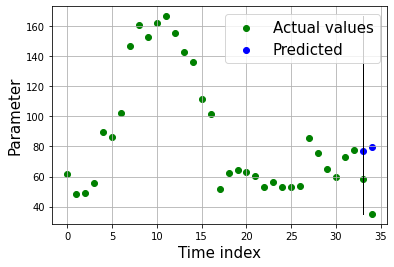

In [44]:
predicted_values = fedot_model(train_data = train_data, 
                                 len_forecast = 2)

plot_results(actual_time_series = AMPY,
             predicted_values = predicted_values, 
             len_train_data = len(train_data))

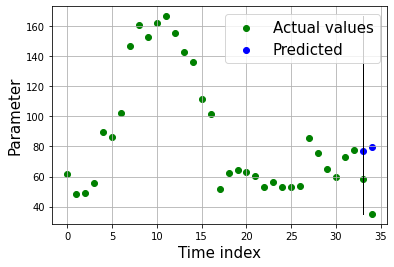

In [37]:
predicted_values = fedot_model(train_data = train_data, 
                                 len_forecast = 2,
                                 window_size = 30)


plot_results(actual_time_series = AMPY,
             predicted_values = predicted_values, 
             len_train_data = len(train_data))

In [34]:
predicted_values

array([76.96325305, 79.41117306])

In [35]:
test_data

array([58.136, 35.171])

Now i try validation for all companies

In [48]:
Validation_small_rev = companies_validation(Test_DF_small,'rev', fedot_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', fedot_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', fedot_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', fedot_model, mean_absolute_error)

2023-02-10 01:58:56,720 - LaggedTransformationImplementation - Warning: window size of lagged transformation was changed from 30 to 11.
2023-02-10 01:58:56,741 - LaggedTransformationImplementation - Warning: window size of lagged transformation was changed from 30 to 12.
2023-02-10 01:58:56,761 - LaggedTransformationImplementation - Warning: window size of lagged transformation was changed from 30 to 13.
2023-02-10 01:58:56,803 - LaggedTransformationImplementation - Warning: window size of lagged transformation was changed from 30 to 14.
2023-02-10 01:58:56,832 - LaggedTransformationImplementation - Warning: window size of lagged transformation was changed from 30 to 15.
2023-02-10 01:58:56,859 - LaggedTransformationImplementation - Warning: window size of lagged transformation was changed from 30 to 16.
2023-02-10 01:58:56,886 - LaggedTransformationImplementation - Warning: window size of lagged transformation was changed from 30 to 17.
2023-02-10 01:58:56,917 - LaggedTransformationIm

In [50]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    109.840196
dtype: float64
op_in    72.675673
dtype: float64
rev    450.193068
dtype: float64
op_in    234.528025
dtype: float64


The results are better than using AML, but still on average worse than the usual naive model. However, for determining the op_in for large companies, the model showed the best result.

Random forest

In [32]:
Validation_small_rev = companies_validation(Test_DF_small,'rev', random_forest_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', random_forest_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', random_forest_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', random_forest_model, mean_absolute_error)

In [33]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    132.415563
dtype: float64
op_in    61.967146
dtype: float64
rev    877.058145
dtype: float64
op_in    351.478918
dtype: float64


Some graphs for different models

In [34]:
Some_companies_small = Test_DF_small.company_name.unique()[:2]
Some_companies_midlle = Test_DF_midlle.company_name.unique()[:2]

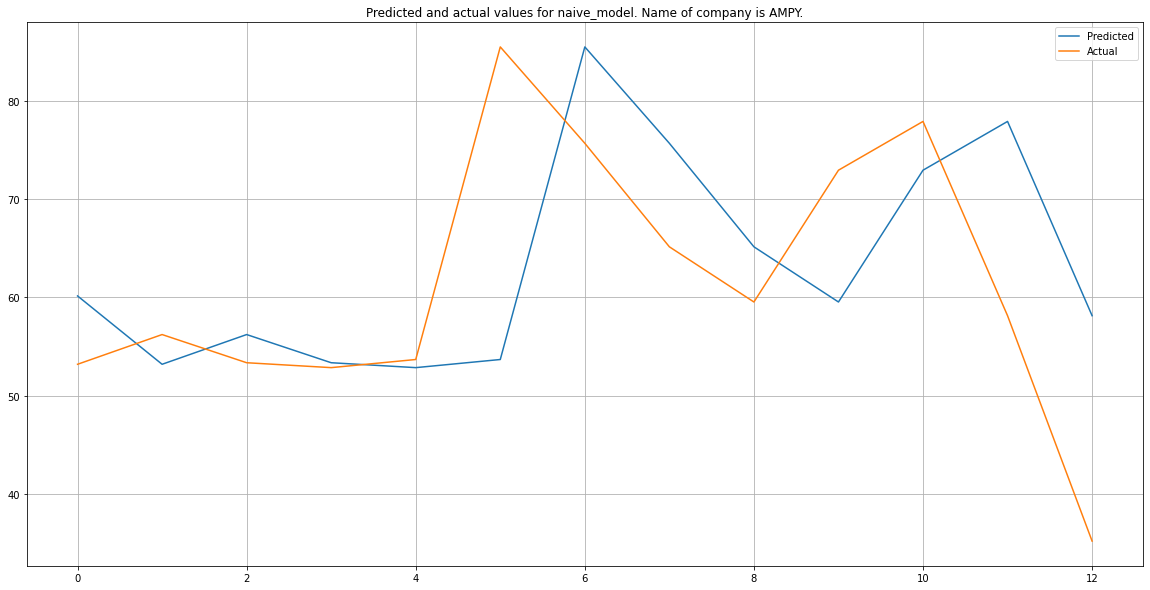

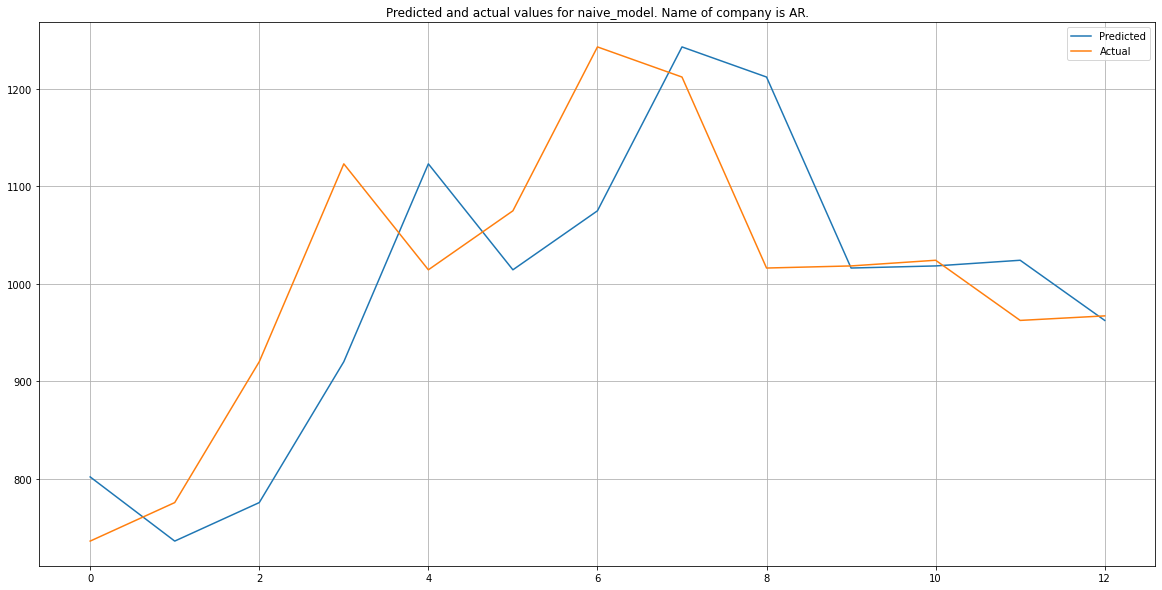

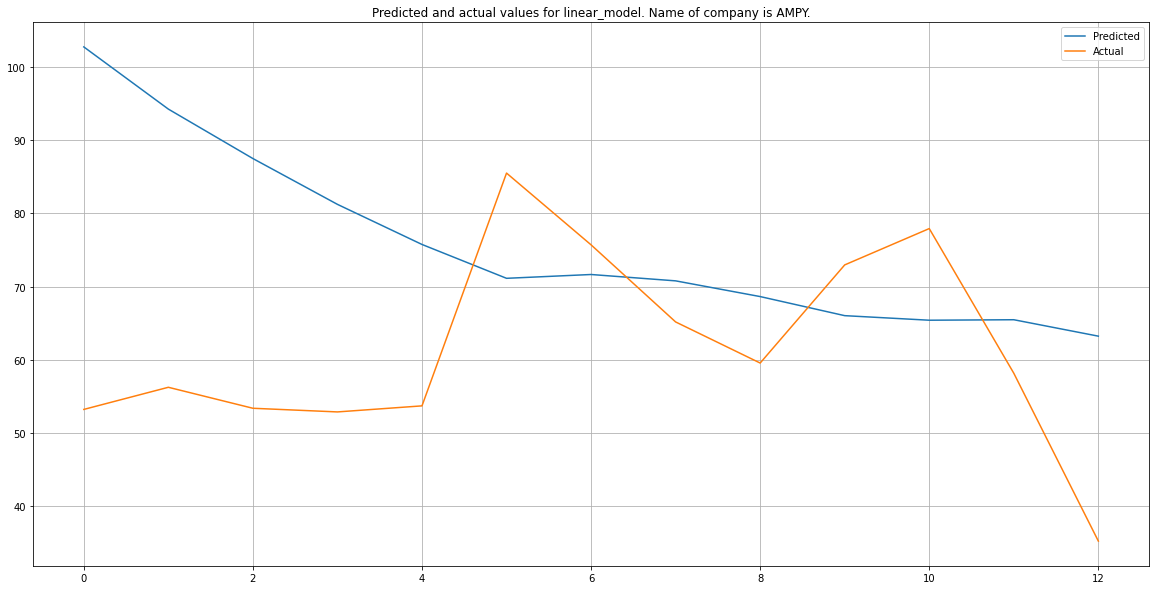

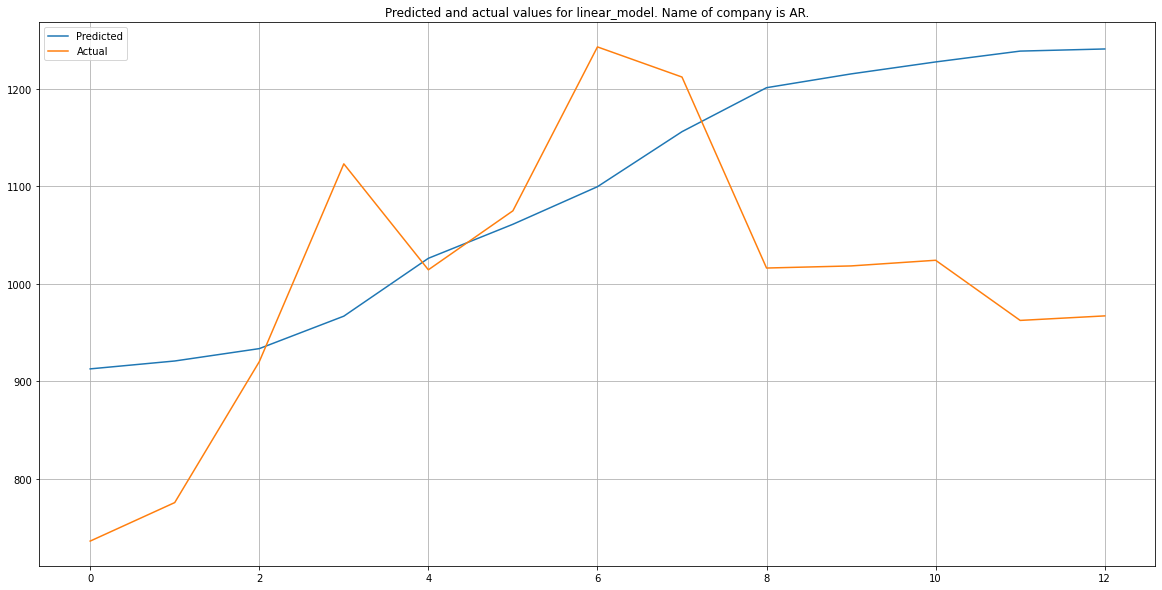

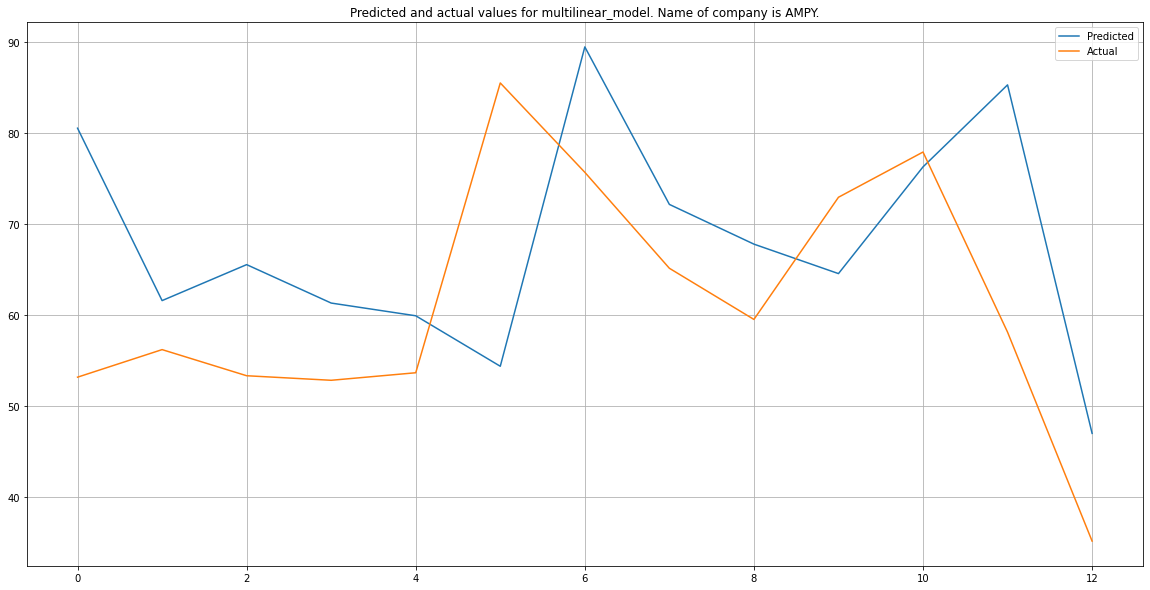

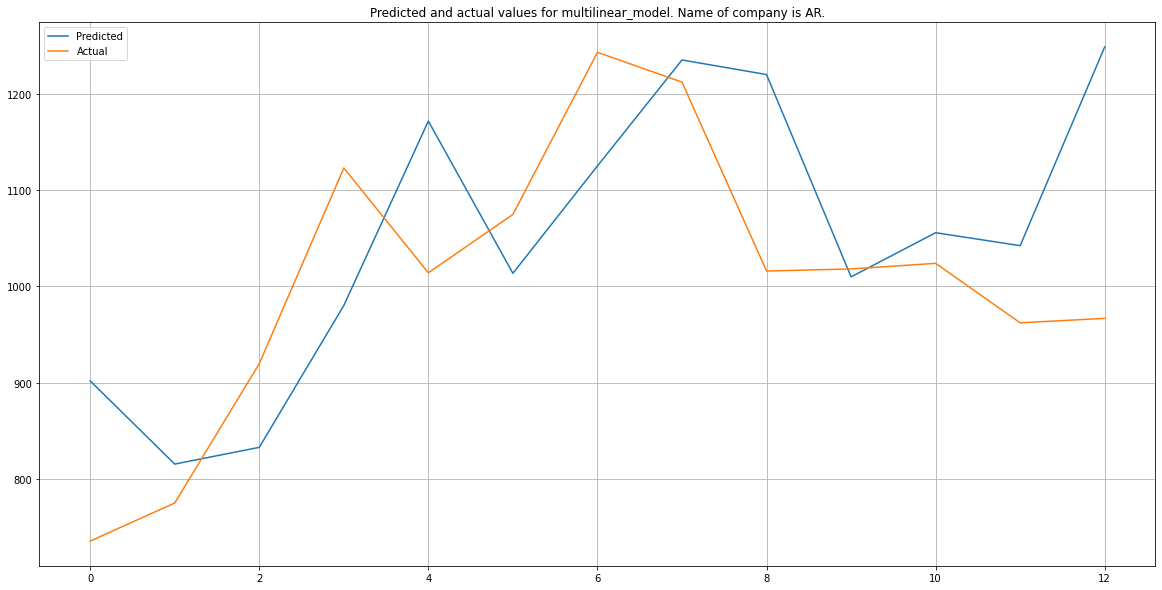

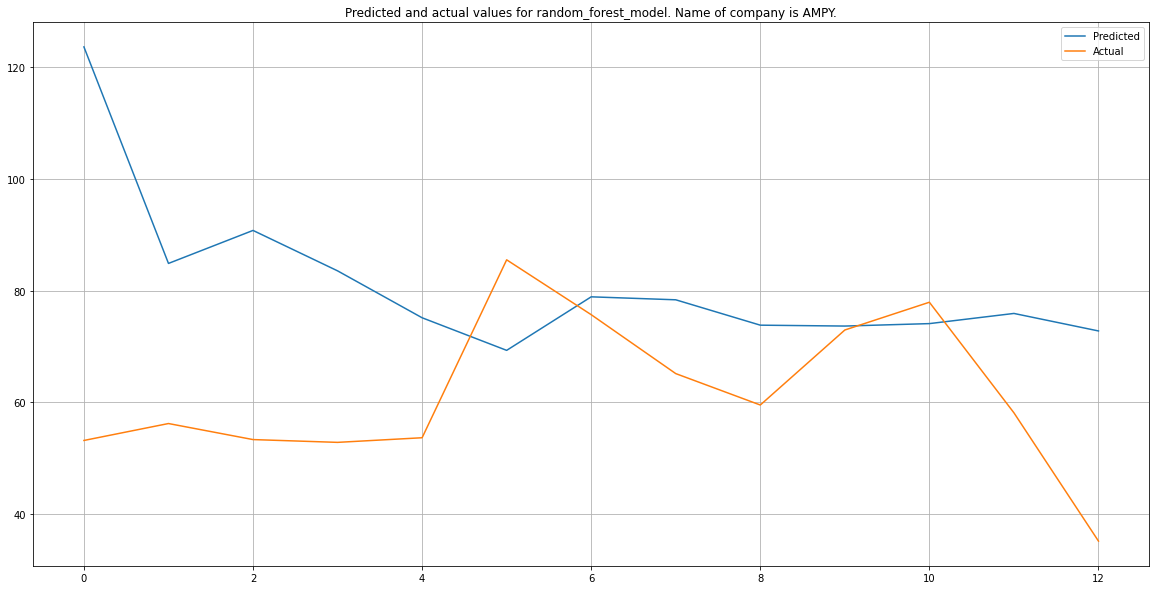

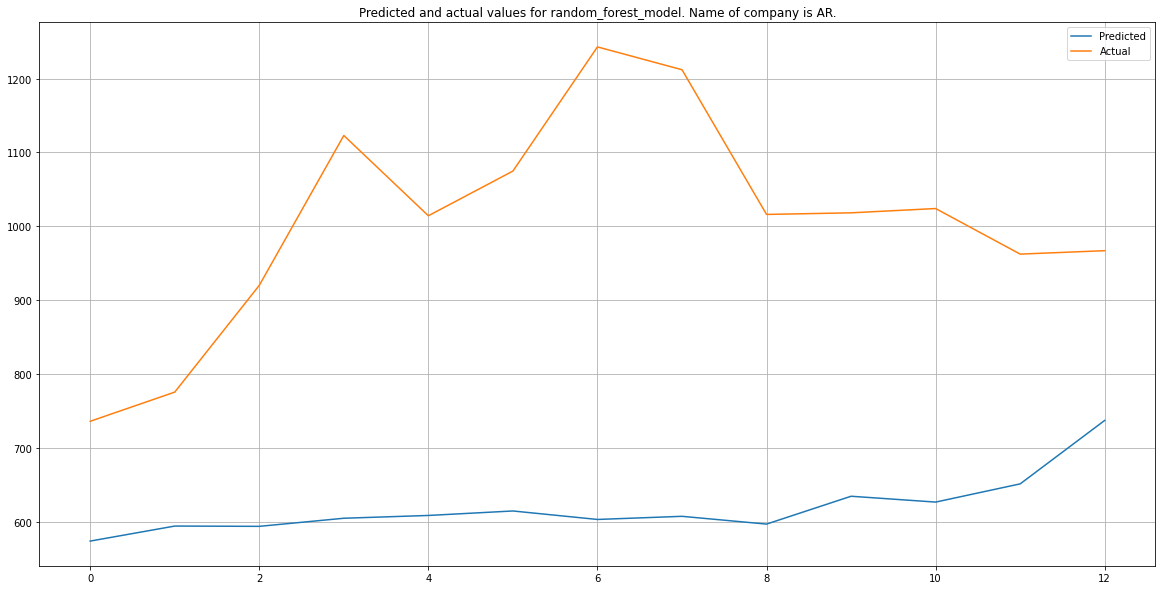

,rev
AMPY,22.737062
AR,387.731281


In [35]:
companies_validation(Test_DF_small[Test_DF_small['company_name'].isin(Some_companies_small)] ,'rev', naive_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_small[Test_DF_small['company_name'].isin(Some_companies_small)] ,'rev', linear_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_small[Test_DF_small['company_name'].isin(Some_companies_small)] ,'rev', multilinear_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_small[Test_DF_small['company_name'].isin(Some_companies_small)] ,'rev', random_forest_model, mean_absolute_error, plot = True)

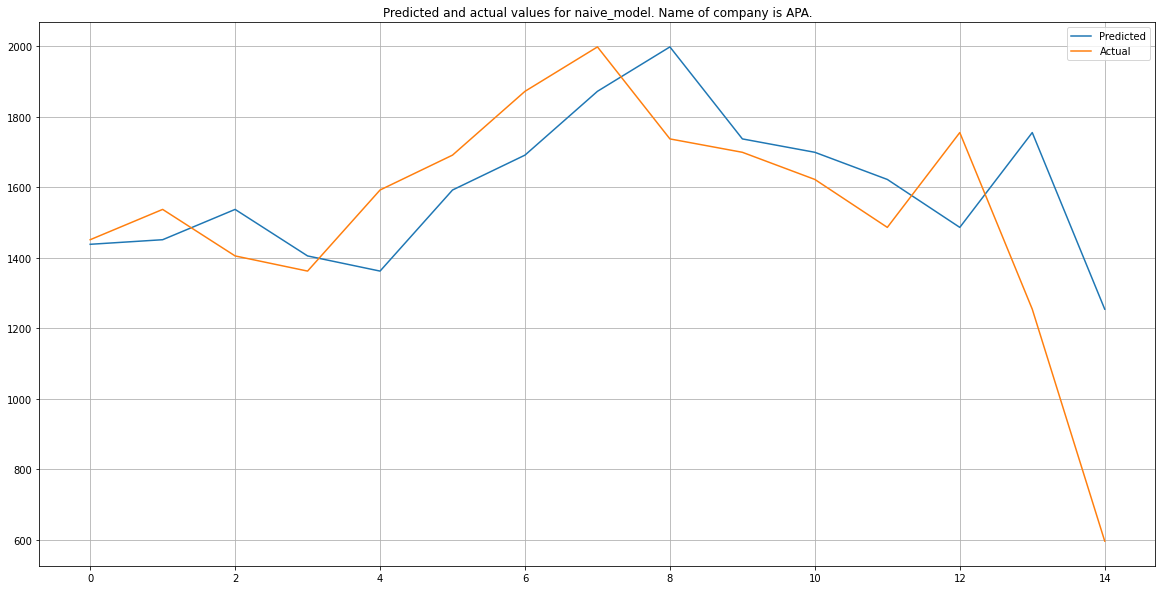

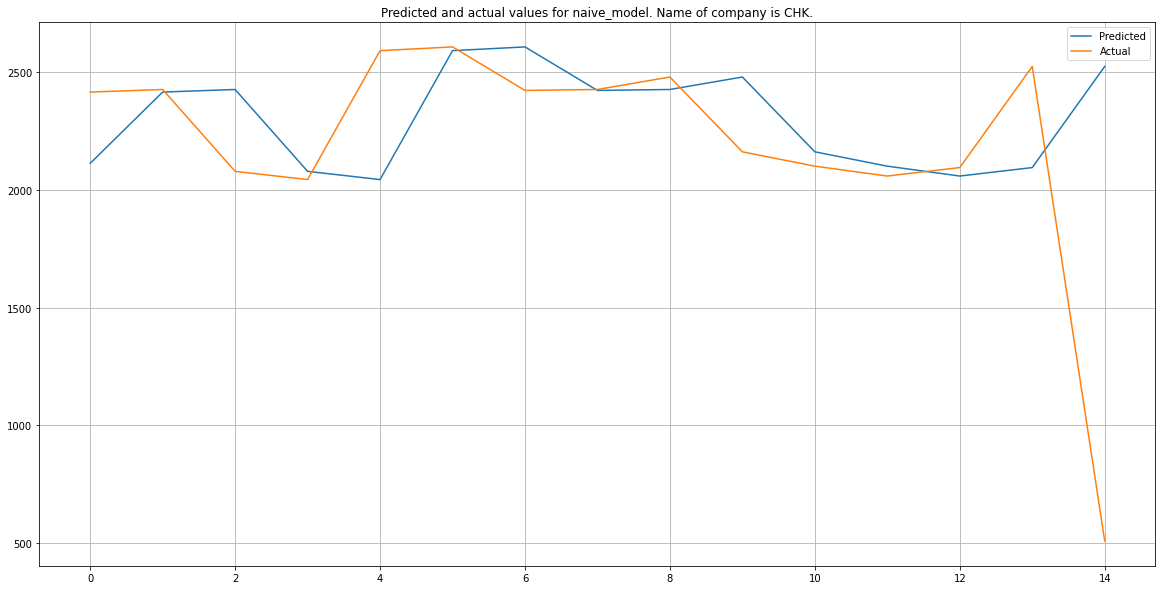

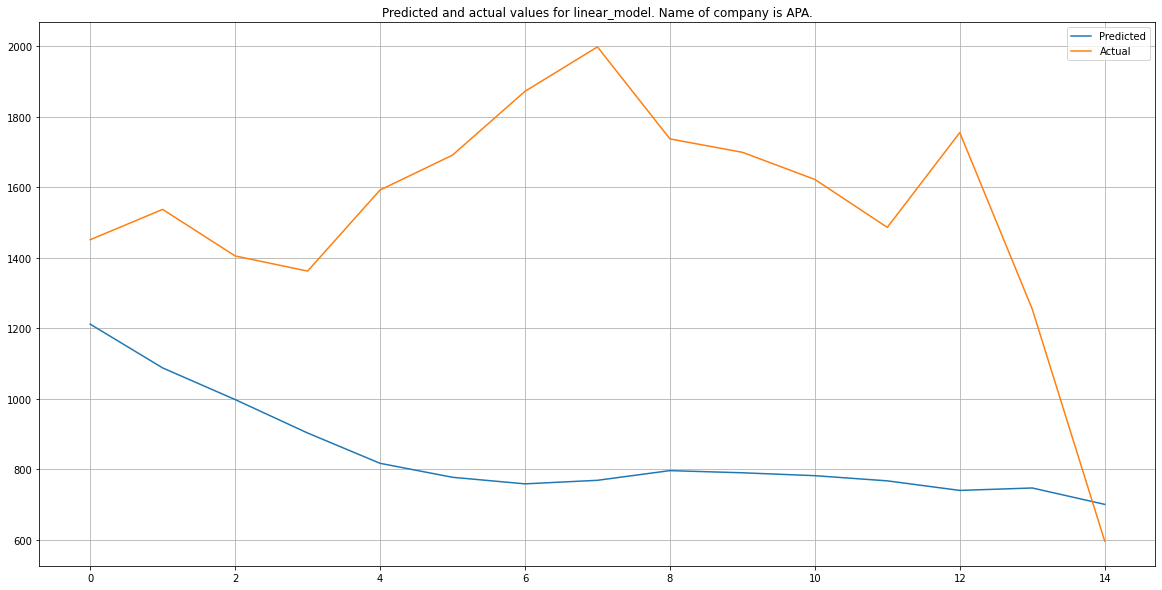

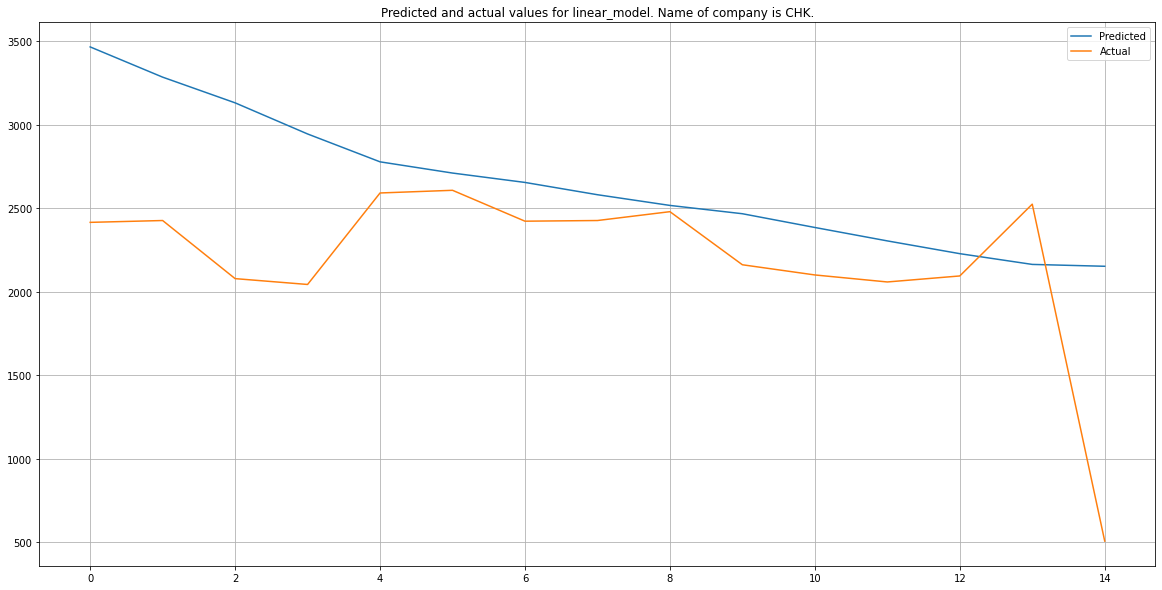

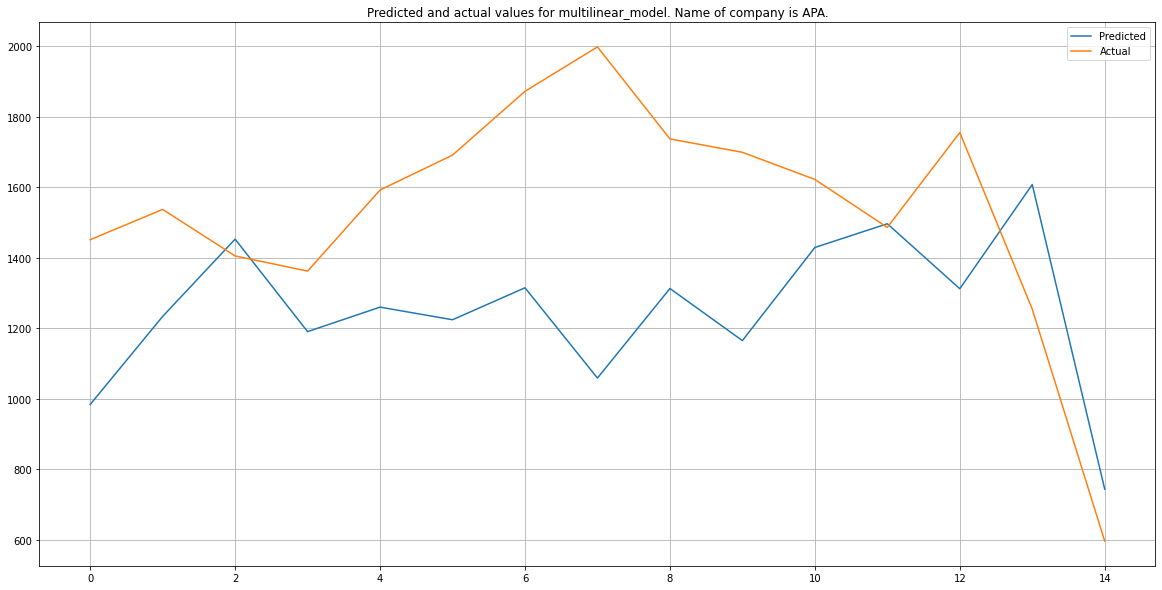

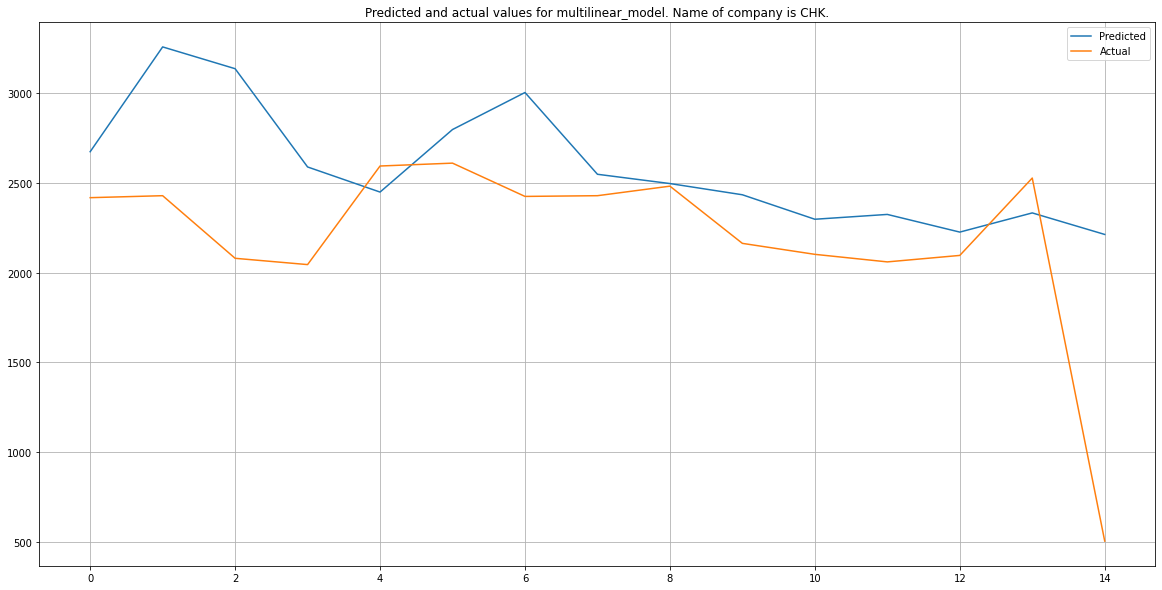

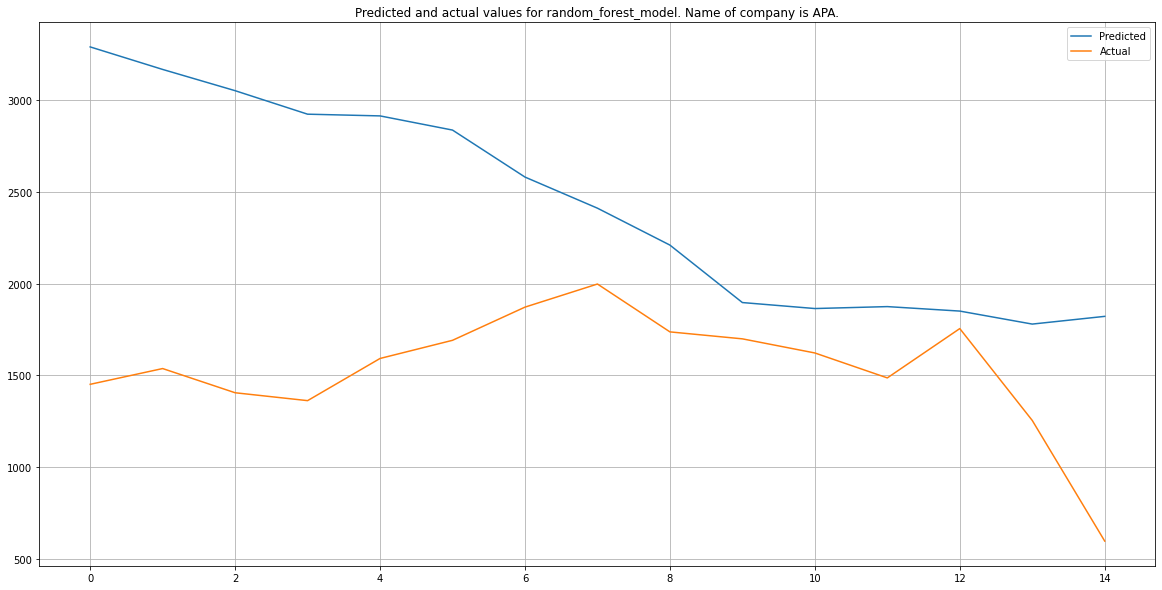

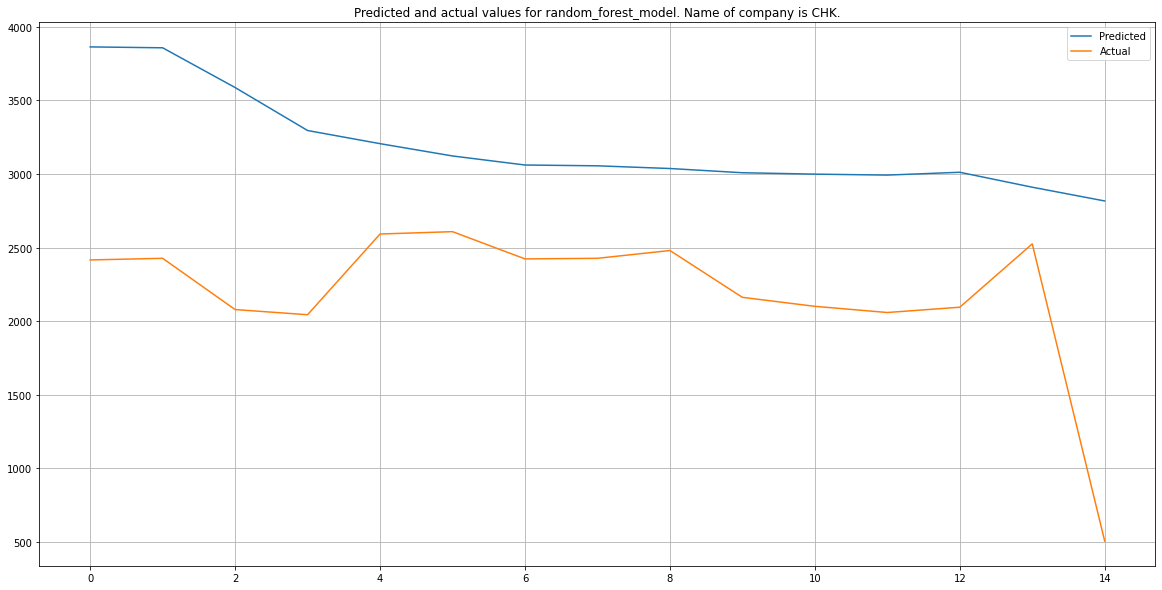

,rev
APA,894.840666
CHK,991.389995


In [36]:
companies_validation(Test_DF_midlle[Test_DF_midlle['company_name'].isin(Some_companies_midlle)] ,'rev', naive_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_midlle[Test_DF_midlle['company_name'].isin(Some_companies_midlle)] ,'rev', linear_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_midlle[Test_DF_midlle['company_name'].isin(Some_companies_midlle)] ,'rev', multilinear_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_midlle[Test_DF_midlle['company_name'].isin(Some_companies_midlle)] ,'rev', random_forest_model, mean_absolute_error, plot = True)